In [ ]:
# @title Carregamento de bibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# pipelines e transformadores
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer

# codificação de variáveis
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

# normalização
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# dados faltantes
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# modelagem
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# seleção de modelos
from sklearn.model_selection import (
    train_test_split, KFold, ShuffleSplit, cross_validate, GridSearchCV, RandomizedSearchCV
)

# métricas de avaliação para classificação
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# métricas de avaliação para regressão
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# @title Leitura do conjunto e criação do dicionário de dados

df = pd.read_csv("https://raw.githubusercontent.com/atlantico-academy/datasets/refs/heads/main/tips.csv")

# @title Dicionário de dados
df_dict = pd.DataFrame([
    {
        "variavel": "total_bill",
        "descricao": "Total pago da conta em dólares.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "tip",
        "descricao": "Valor da gorjeta dada ao garçom em dólares.",
        "tipo": "quantitativa",
        "subtipo": "contínua",
    },
    {
        "variavel": "sex",
        "descricao": "Gênero do cliente (Male/Female).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "smoker",
        "descricao": "Indica se o cliente é fumante (Yes/No).",
        "tipo": "qualitativa",
        "subtipo": "nominal",
    },
    {
        "variavel": "day",
        "descricao": "Dia da semana da refeição (Thur, Fri, Sat, Sun).",
        "tipo": "qualitativa",
        "subtipo": "ordinal",
    },
    {
        "variavel": "time",
        "descricao": "Período do dia em que ocorreu a refeição (Lunch/Dinner).",
        "tipo": "qualitativa",
        "subtipo": "ordinal",
    },
    {
        "variavel": "size",
        "descricao": "Número de pessoas na mesa.",
        "tipo": "quantitativa",
        "subtipo": "discreta",
    }
])
df_dict

,variavel,descricao,tipo,subtipo
0,total_bill,Total pago da conta em dólares.,quantitativa,contínua
1,tip,Valor da gorjeta dada ao garçom em dólares.,quantitativa,contínua
2,sex,Gênero do cliente (Male/Female).,qualitativa,nominal
3,smoker,Indica se o cliente é fumante (Yes/No).,qualitativa,nominal
4,day,"Dia da semana da refeição (Thur, Fri, Sat, Sun).",qualitativa,ordinal
5,time,Período do dia em que ocorreu a refeição (Lunc...,qualitativa,ordinal
6,size,Número de pessoas na mesa.,quantitativa,discreta


In [ ]:
# @title Seleção de variáveis e separação de entradas e saídas
target_variable = ['tip']
useless_variables =  (
    df_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)
unused_variables = useless_variables + target_variable
nominal_variables = (
    df_dict
    .query("subtipo == 'nominal' and variavel not in @unused_variables")
    .variavel
    .to_list()
)
ordinal_variables = (
    df_dict
    .query("subtipo == 'ordinal' and variavel not in @unused_variables")
    .variavel
    .to_list()
)
continuous_variables = (
    df_dict
    .query("subtipo == 'contínua' and variavel not in @unused_variables")
    .variavel
    .to_list()
)
discrete_variables = (
    df_dict
    .query("subtipo == 'discreta' and variavel not in @unused_variables")
    .variavel
    .to_list()
)

# separar entradas e saídas
X = df.drop(columns=unused_variables)
y = df[target_variable]

In [ ]:
# @title Preprocessamento de dados

# variáveis discretas
discrete_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='median')), # tratamento de dados faltantes
    # tratamento de dados discrepantes
    ("normalization",  MinMaxScaler())# normalização
])
# variáveis contínuas
continuous_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')), # tratamento de dados faltantes
    # tratamento de dados discrepantes
    ("normalization",  MinMaxScaler())# normalização
])
# variáveis ordinal
ordinal_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ("encoding", OrdinalEncoder(categories=[['Thur', 'Fri', 'Sat', 'Sun'], ['Lunch', 'Dinner']])) # codificação de variáveis
])
# variáveis nominais
nominal_preprocessing = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ("encoding", OneHotEncoder(sparse_output=False)) # , drop='if_binary'
])

# preprocessamento geral
preprocessing = ColumnTransformer(transformers=[
    ("ordinal", ordinal_preprocessing, ordinal_variables),
    ("nominal", nominal_preprocessing, nominal_variables),
    ("discrete", discrete_preprocessing, discrete_variables),
    ("continuous", continuous_preprocessing, continuous_variables),
], remainder='passthrough')

In [ ]:
KNeighborsRegressor

In [ ]:
models = [
    {
        "nome": "LRG",
        "objeto": LinearRegression(),
        "hp": {}
    }, {
        "nome": "KNN",
        "objeto": KNeighborsRegressor(),
        "hp": {
            'n_neighbors': np.arange(1, 31, 5), # Número de vizinhos entre 1 e 30
            'weights': ['uniform', 'distance'], # Peso uniforme ou baseado na distância
        }
    }, {
        "nome": "DTR",
        "objeto": DecisionTreeRegressor(random_state=42),
        "hp": {
            'max_depth': [None] + list(np.arange(2, 20, 4)), # Profundidade máxima
            'max_features': [None, 'sqrt', 'log2'] # Máximo de features
        }
    }, {
        "nome": "SVR",
        "objeto": SVR(max_iter=100),
        "hp": {
            'C': np.logspace(-3, 3, 10),     # Regularização
            'epsilon': np.logspace(-4, 0, 10),  # Insensibilidade à margem
            'kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel a ser usado
        }
    }
]

In [ ]:

n_splits = 10
kfold_split = KFold(n_splits=n_splits, shuffle=True, random_state=42)
monte_carlo_split_hop = ShuffleSplit(n_splits=10, random_state=42, test_size=.2,)

model_metrics = []
for model in models:
    print(f'Rodando modelo {model["nome"]}')
    best_model = GridSearchCV(
        model['objeto'], param_grid=model['hp'],
        scoring='neg_mean_absolute_error',
        cv=monte_carlo_split_hop
    )
    approach = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("model", best_model)
    ])
    metrics = cross_validate(
        estimator=approach, X=X, y=y.values.squeeze(), cv=kfold_split,
        scoring=[
            'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'
        ]
    )
    metrics['modelo'] = [model['nome']] * n_splits
    model_metrics.append(pd.DataFrame(metrics))
    # break
    # display(pd.DataFrame(metrics).agg(['mean', 'std']).transpose())

Rodando modelo LRG
Rodando modelo KNN
Rodando modelo DTR
Rodando modelo SVR


A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarn

In [ ]:
pd.concat(model_metrics, axis=0).groupby('modelo').agg(['mean', 'std']).transpose()

modelo                                             DTR       KNN       LRG  \
fit_time                                mean  0.422835  0.340603  0.035144   
                                        std   0.083114  0.062595  0.004133   
score_time                              mean  0.015427  0.015687  0.011569   
                                        std   0.011889  0.003148  0.000650   
test_neg_mean_absolute_error            mean -0.859069 -0.838994 -0.758106   
                                        std   0.195105  0.146387  0.193529   
test_neg_mean_absolute_percentage_error mean -0.319952 -0.310738 -0.281836   
                                        std   0.085461  0.069279  0.083773   
test_neg_mean_squared_error             mean -1.402041 -1.322863 -1.094903   
                                        std   0.826977  0.724746  0.540152   

modelo                                              SVR  
fit_time                                mean  11.698339  
                                        std    0.345333  
score_time                              mean   0.014378  
                                        std    0.003064  
test_neg_mean_absolute_error            mean  -0.814905  
                                        std    0.200914  
test_neg_mean_absolute_percentage_error mean  -0.292122  
                                        std    0.075656  
test_neg_mean_squared_error             mean  -1.234666  
                                        std    0.660943

In [ ]:
# @title Calcular métricas (avaliar)
acc = accuracy_score(y_test, y_test_hat)
f1 = f1_score(y_test, y_test_hat)
recall = recall_score(y_test, y_test_hat)
precision = precision_score(y_test, y_test_hat)
cm = confusion_matrix(y_test, y_test_hat)
# roc_auc = roc_auc_score(y_test, y_proba)
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)

ValueError: continuous is not supported

F1 Score: 0.9541284403669725
Recall: 0.9629629629629629
Precision: 0.9454545454545454


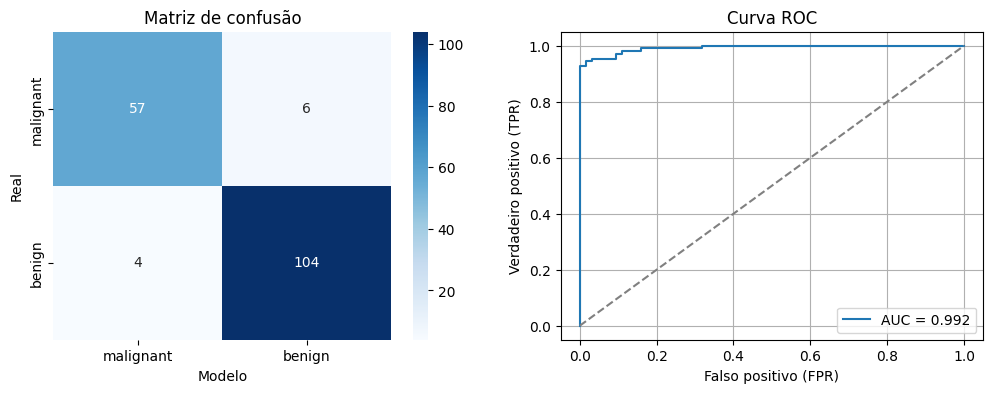

In [ ]:
# @title Mostrar resultados
# print("Accuracy:", acc)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
# print("AUC-ROC:", roc_auc)
# print("Confusion Matrix:\n", cm)

# Plotar matriz de confusão e curva ROC
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=target_names, yticklabels=target_names, ax=axes[0]
)
axes[0].set(xlabel="Modelo", ylabel="Real", title="Matriz de confusão")

plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set(xlabel="Falso positivo (FPR)", ylabel="Verdadeiro positivo (TPR)", title="Curva ROC")
axes[1].legend()
axes[1].grid(True)
plt.show()